# Riddler Classic 

For proper formatting I recommend viewing this notebook using [nbviewer](https://nbviewer.jupyter.org/github/Booleans/riddler-538/blob/main/flip-to-freedom.ipynb).

## Can You Flip Your Way To Freedom?

**2020-05-01**: https://fivethirtyeight.com/features/can-you-flip-your-way-to-freedom/

From Bart Wright comes a rhetorical question from a famed soliloquy, “To flip, or not to flip?”:

You are locked in the dungeon of a faraway castle with three fellow prisoners (i.e., there are four prisoners in total), each in a separate cell with no means of communication. But it just so happens that all of you are logicians (of course).

To entertain themselves, the guards have decided to give you all a single chance for immediate release. Each prisoner will be given a fair coin, which can either be fairly flipped one time or returned to the guards without being flipped. If all flipped coins come up heads, you will all be set free! But if any of the flipped coins comes up tails, or if no one chooses to flip a coin, you will all be doomed to spend the rest of your lives in the castle’s dungeon.

The only tools you and your fellow prisoners have to aid you are random number generators, which will give each prisoner a random number, uniformly and independently chosen between zero and one.

What are your chances of being released?

*Extra credit:* Instead of four prisoners, suppose there are N prisoners. Now what are your chances of being released?

Initial thoughts: The prisoners' ideal scenario is to have only one person flip. This generates a release probability of 50%, which is the maximum value possible when your freedom is determined by a single flip of a fair coin. The prisoners need to choose a threshold and if they receive a number from the guards that is under this threshold they will agree to flip the coin. This is a binomial distribution with 4 "trials" with some probability of "success" equal to their threshold value. There are 5 possibilties for how many prisoners end up flipping the coin (0, 1, 2, 3, or 4) and altering this threshold changes the relative plausibilties of each scenario.

In [1]:
import numpy as np
from scipy import stats
from scipy.optimize import minimize_scalar
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
def get_neg_prob_release_for_threshold(threshold, n_prisoners=4):
    '''
    Function that returns the probability of the prisoners being released when prisoners choose
    to flip a coin only if their number from the guards is above a certain threshold.
    
    Args:
        threshold (float): Threshold below which a prisoner will choose to flip a coin. For example,
        a threshold of .70 means a prisoner will decide to flip the fair coin if his randomly assigned 
        number was less than .70.
                            
        n_prisoners (int): The number of prisoners involved in this "game".

    Returns:
        float: Returns a float between 0 and -1 that represents the negative of the probability
        of the prisoners being released. The purpose of this negative is to be able to pass the
        function into scipy optimize.
    '''
    # We can ignore the probability of 0 coins being flipped because that leads to a loss.
    num_flips = np.arange(1, n_prisoners+1)
    dist = stats.binom(n_prisoners, threshold)
    # Calculate the probability of 1 to n coins being flipped given the current threshold.
    p_num_flips = dist.pmf(num_flips)
    
    dist = stats.binom(num_flips, 0.5)
    # We want the probability of every flip coming up heads, given the number of flips. This leads to release.
    p_all_heads = dist.pmf(num_flips)
    
    return -1*np.sum(p_num_flips * p_all_heads)

Let's visualize how the probability of the prisoners being released changes depending on the threshold selected.

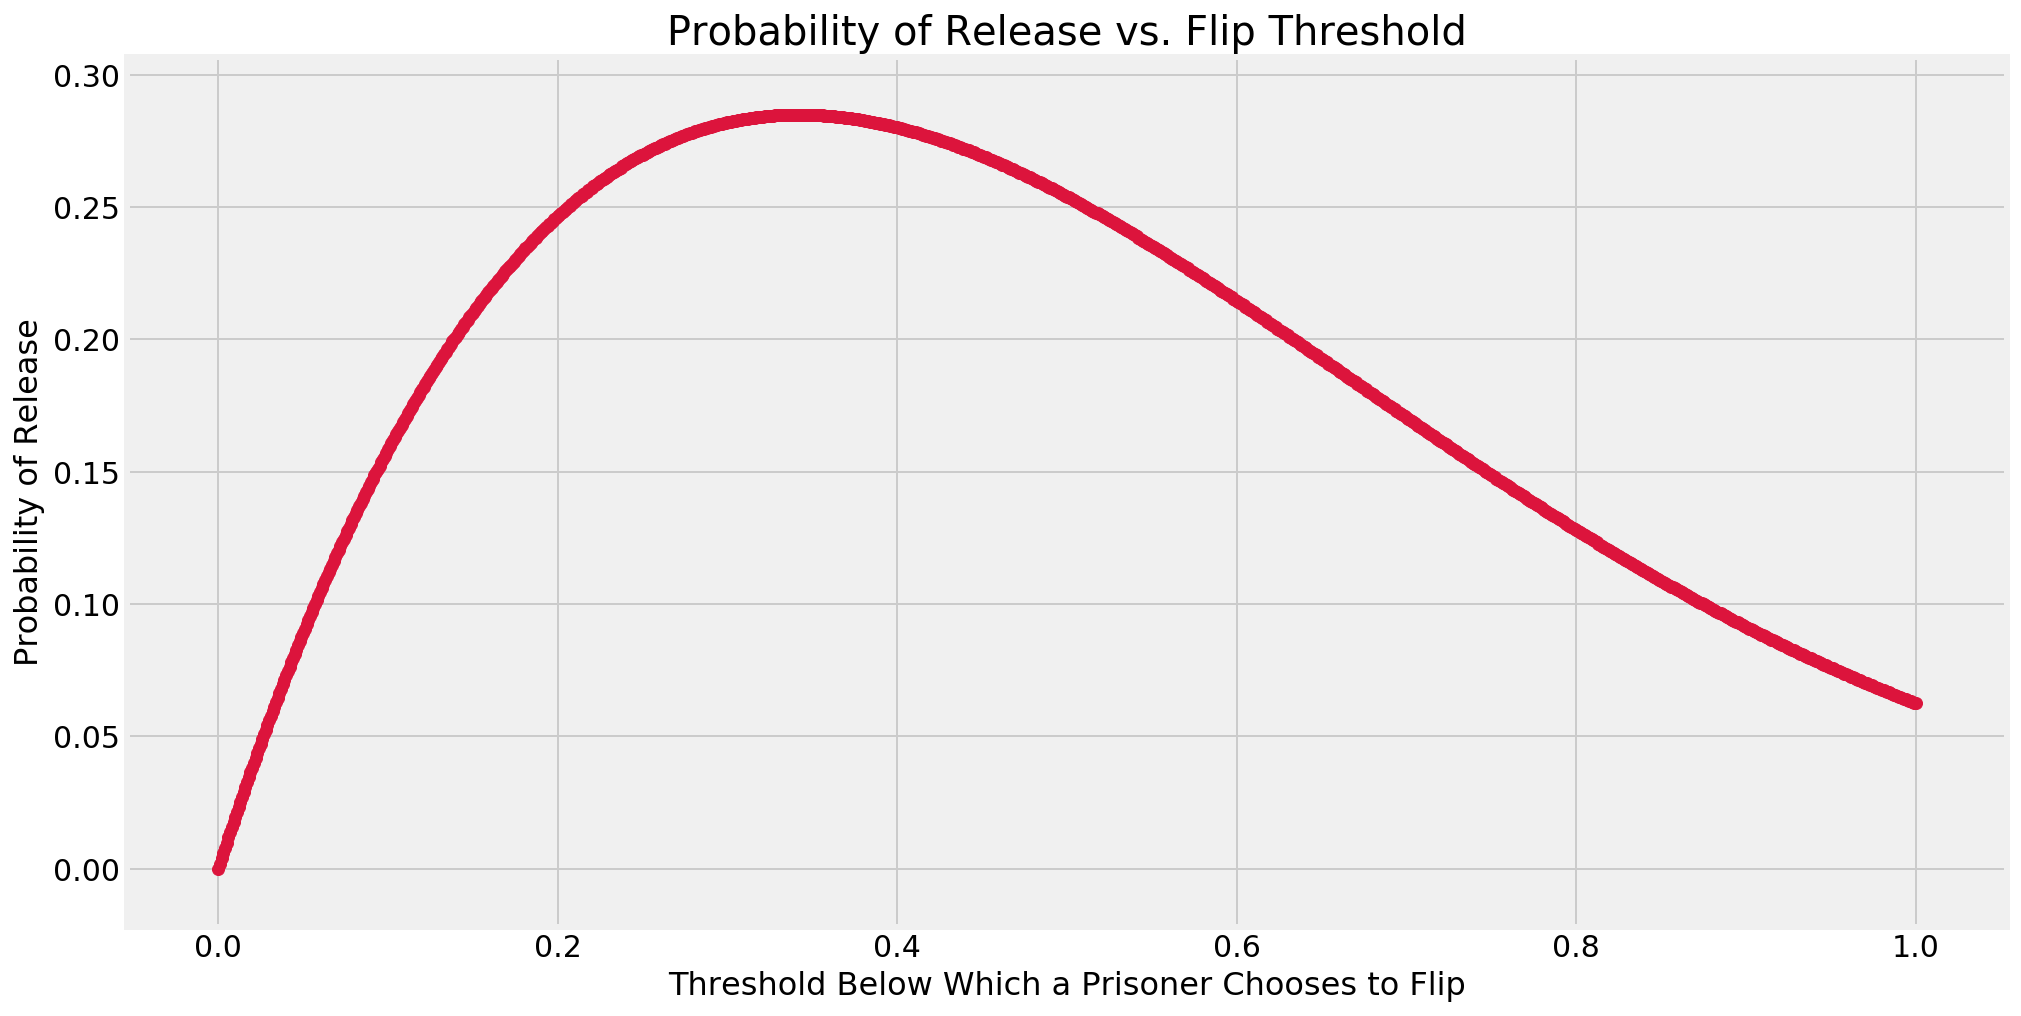

In [3]:
thresholds = np.linspace(0, 1.0, 1001)
p_release = np.zeros(1001)

for i, threshold in enumerate(thresholds):
    p_release[i] = -1*get_neg_prob_release_for_threshold(threshold)

fig, ax = plt.subplots(figsize=(15, 8))
ax.scatter(thresholds, p_release, color='crimson')
ax.set_title('Probability of Release vs. Flip Threshold', fontsize=20)
ax.set_ylabel('Probability of Release', fontsize=16)
ax.tick_params(axis='y', labelsize=15);
ax.set_xlabel('Threshold Below Which a Prisoner Chooses to Flip', fontsize=16)
ax.tick_params(axis='x', labelsize=15);

Now let's write a function that will return the ideal threshold along with the probability of being released at that threshold. I was originally just testing 1000 different threshold values between 0 and 1 but switched to using the `minimize_scalar` function from `scipy.optimize` for a quicker, more precise result.

In [4]:
def get_best_prob_release(n_prisoners=4):
    result = minimize_scalar(get_neg_prob_release_for_threshold, bounds=(0, 1), args=(n_prisoners), method='bounded')
    # Let's return both the probability of release along with the threshold above which a prisoner should flip.
    return -1*result['fun'], result['x']

In [5]:
get_best_prob_release()

(0.28484236891760556, 0.34203573002489845)

There we have it, the prisoners should flip the coin if their number from the guards is below `~.342`. This yields approximately a `28.48%` chance of being released. 

Let's experiment though and see how the threshold and probability changes when we change the number of prisoners.

In [6]:
n_prisoners = np.arange(1, 101)
p_release = np.zeros(100)
threshold_best = np.zeros(100)

for i, n in enumerate(n_prisoners):
    prob, threshold = get_best_prob_release(n_prisoners=n)
    p_release[i] = prob
    threshold_best[i] = threshold    

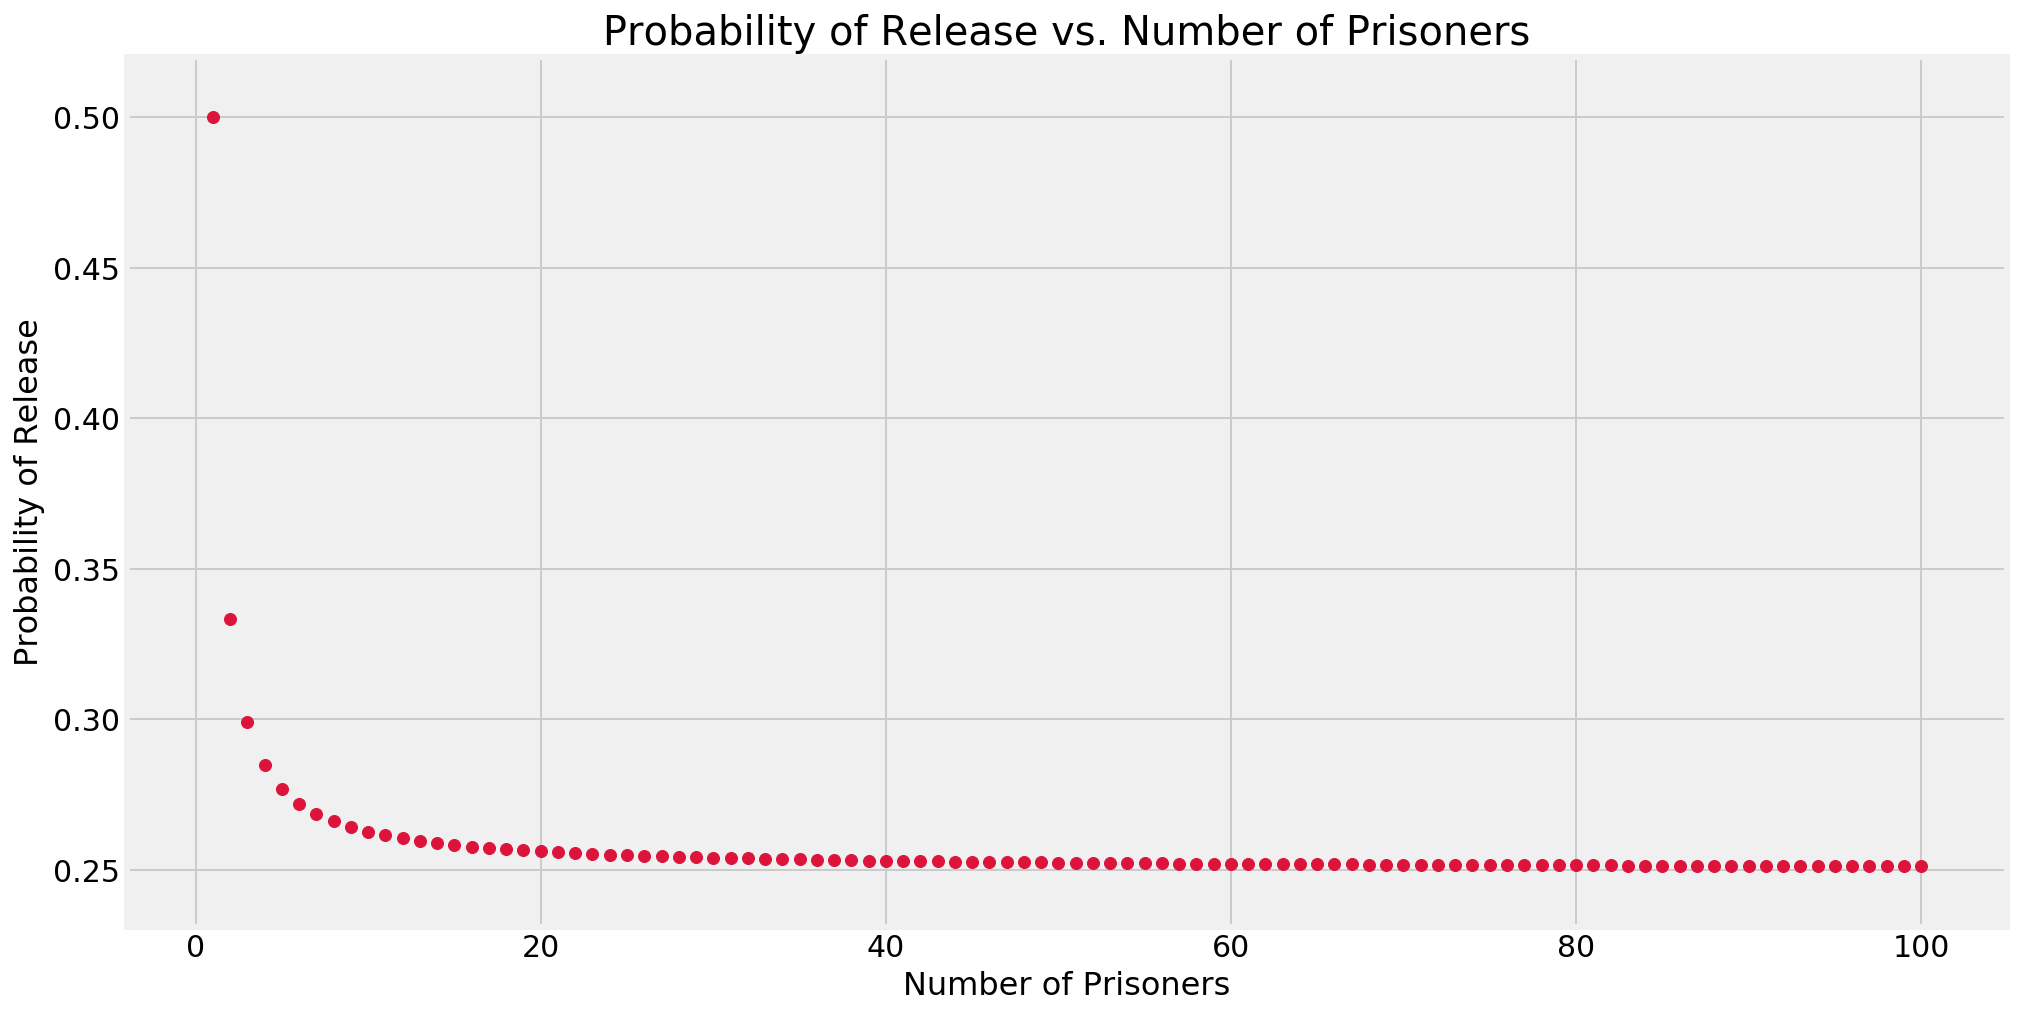

In [7]:
fig, ax = plt.subplots(figsize=(15, 8))
ax.scatter(n_prisoners, p_release, color='crimson')
ax.set_title('Probability of Release vs. Number of Prisoners', fontsize=20)
ax.set_ylabel('Probability of Release', fontsize=16)
ax.tick_params(axis='y', labelsize=15);
ax.set_xlabel('Number of Prisoners', fontsize=16)
ax.tick_params(axis='x', labelsize=15);

As expected, a single prisoner has a 50% chance of being released due to being guaranteed to be the only prisoner flipping a coin. As more and more prisoners are added the probability begins dropping and converging to what appears to be 25%. 

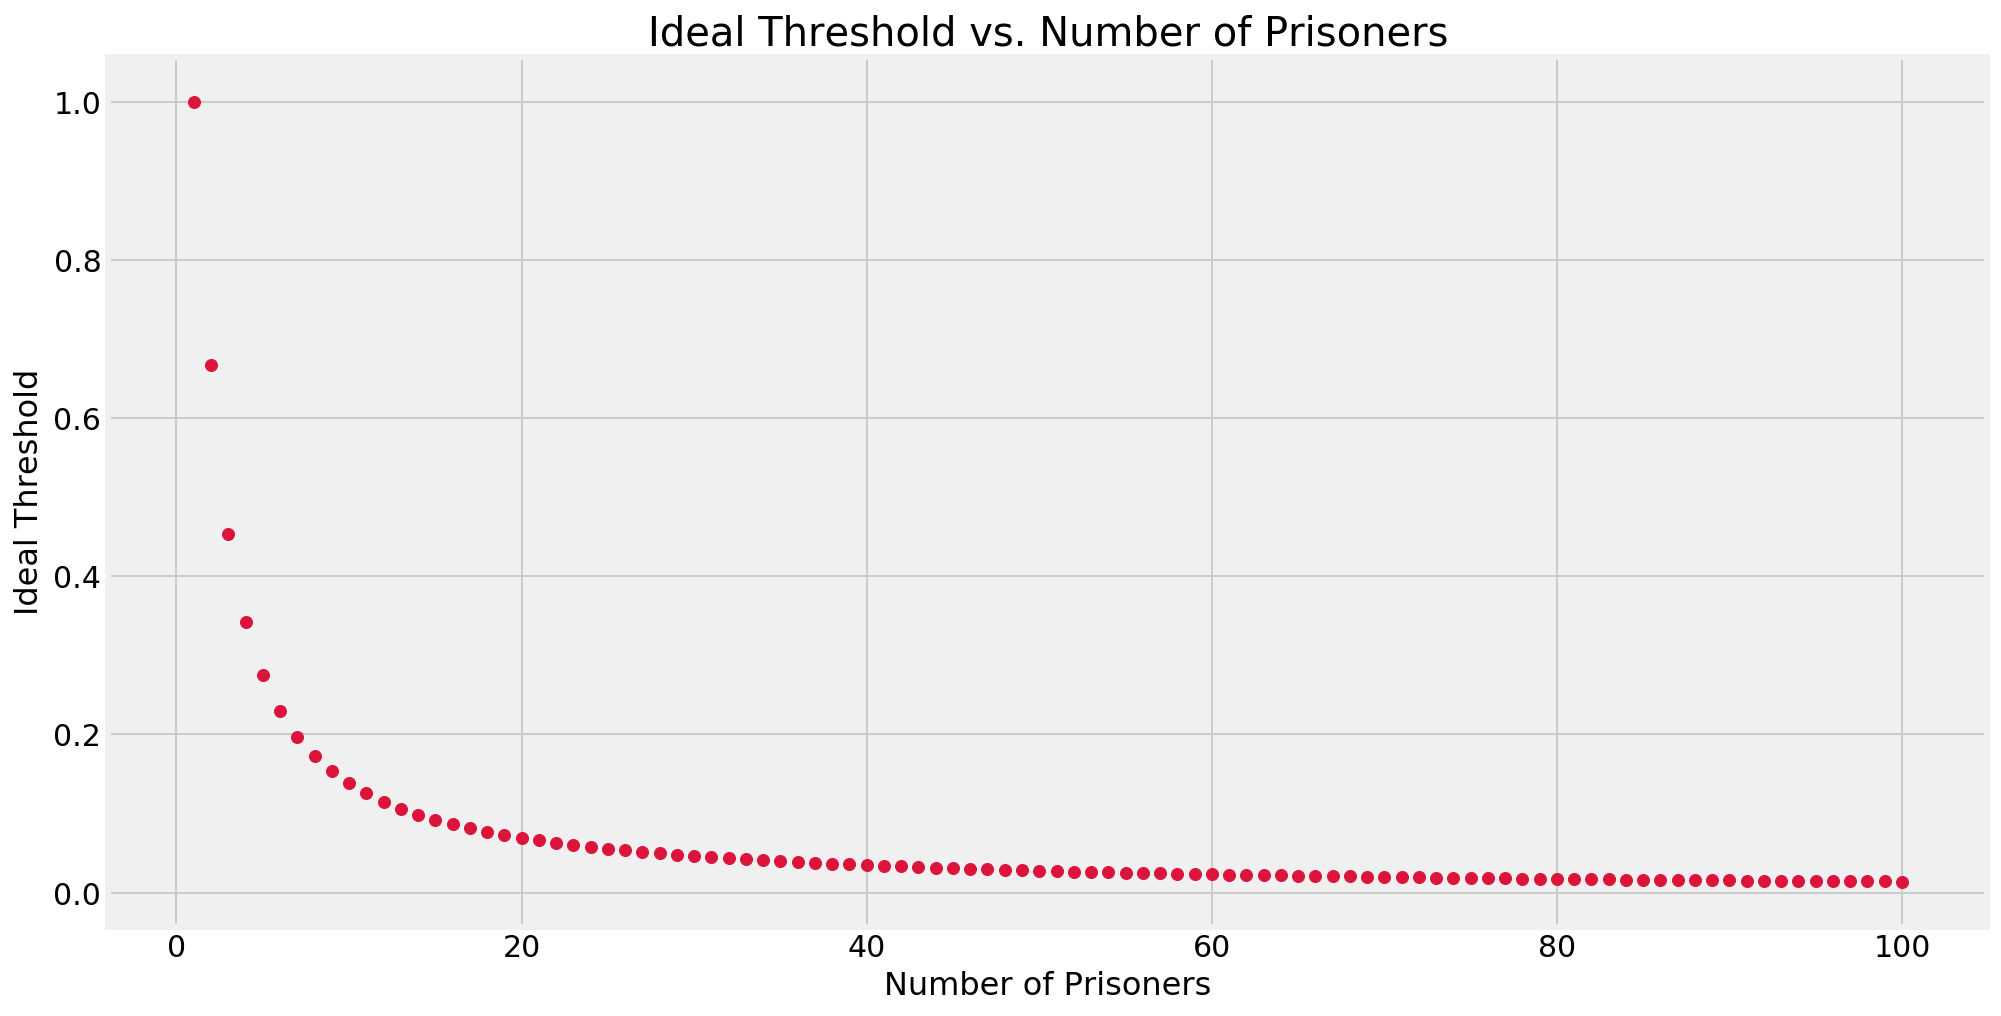

In [8]:
fig, ax = plt.subplots(figsize=(15, 8))
ax.scatter(n_prisoners, threshold_best, color='crimson')
ax.set_title('Ideal Threshold vs. Number of Prisoners', fontsize=20)
ax.set_ylabel('Ideal Threshold', fontsize=16)
ax.tick_params(axis='y', labelsize=15);
ax.set_xlabel('Number of Prisoners', fontsize=16)
ax.tick_params(axis='x', labelsize=15);

This chart also matches our intuition. A single prisoner will choose a threshold of 1.0, meaning he will always flip. As we add more prisoners the threshold will drop lower and lower in an attempt to have just 1 prisoner flipping.

### Simulation

Before deciding to find an exact solution I wrote a simulation of the prisoner's scenario. The code is included below.

In [9]:
def simulate_release_probability(n_prisoners=4, threshold=0.75, n_sims=5*10**6):
    # Each of the 4 prisoners is assigned a random number between 0 and 1.
    nums = np.random.random(size=(n_sims, n_prisoners))
    # Prisoners flip the coin if they're above a certain threshold.
    is_flipping = nums > threshold
    # For every prisoner flipping, see if they got a 1 (heads) from a fair coin.
    flip_results = np.random.binomial(is_flipping, .5)
    # For each simulation we need to make sure at least 1 prisoner flipped.
    someone_flipped = np.any(is_flipping, axis=1)
    # Every prisoner who flipped must have gotten heads in order for the group to be released.
    all_heads = np.all(np.where(is_flipping, flip_results, 1), axis=1)
    
    released = someone_flipped & all_heads
    
    return np.mean(released)